## http client

In [1]:
from concurrent.futures import ThreadPoolExecutor, wait
import time
import tritonclient.http as httpclient
from tqdm import tqdm
from PIL import Image
import numpy as np

def inference(model_name,image_file,mode="single",print_output=True,n_reqs=1):

    if mode == 'sequential':
        e = time.time()
        pred = []
        for i in tqdm(range(n_reqs)):
            pred.append(client(i, image_file, model_name, print_output))
        s = time.time()    
        print('FPS:', n_reqs/(s - e))
        return pred
    
    elif mode == 'single':
        e = time.time()
        pred = client(0, image_file, model_name, print_output)
        s = time.time()    
        print('speed:', (s - e))
        return pred
                
    elif mode == 'concurrent':
        s = time.time()
        with ThreadPoolExecutor(max_workers=10) as executor:
            futures = [
                executor.submit(client,
                                i,
                                image_file,
                                model_name,
                                print_output)
                for i in range(n_reqs)
            ]
            wait(futures)
            for f in futures:
                f.results()
        e = time.time()
        print('FPS:', n_reqs/(e - s))

def client(req_id, image_file, model_name, print_output=True):
    img = np.array(Image.open(image_file))
    img = np.ascontiguousarray(img.transpose(2, 0, 1))
    # Define model's inputs
    inputs = []
    inputs.append(httpclient.InferInput('image__0', img.shape, "UINT8"))
    inputs[0].set_data_from_numpy(img)
    # Define model's outputs
    outputs = []
    outputs.append(httpclient.InferRequestedOutput('bboxes__0'))
    outputs.append(httpclient.InferRequestedOutput('classes__1'))
    outputs.append(httpclient.InferRequestedOutput('masks__2'))
    outputs.append(httpclient.InferRequestedOutput('scores__3'))
    outputs.append(httpclient.InferRequestedOutput('shape__4'))
    # Send request to Triton server
    triton_client = httpclient.InferenceServerClient(
        url="localhost:8000", verbose=False)
    results = triton_client.infer(model_name, inputs=inputs, outputs=outputs)
    response_info = results.get_response()
    outputs = {}
    
    for output_info in response_info['outputs']:
        output_name = output_info['name']
        outputs[output_name] = results.as_numpy(output_name)
        
    return outputs

def get_key_from_value(dict,value):
   return [k for k, v in dict.items() if v == value]

def infer_result_filter(pred,score:float,class_name:str):
    # get filtered index
    idx_list, new_pred = [], {}
    for key in list(pred.keys()):
        new_pred[key] = []
    
    for i in range(len(pred[list(pred.keys())[3]])):
        if pred[list(pred.keys())[3]][i] >= score and pred[list(pred.keys())[1]][i] == get_key_from_value(coco_names,class_name)[0]:
            idx_list.append(i)
            
    # filter result
    for idx in idx_list: 
        for key in list(pred.keys())[:4]:
            if len(new_pred[key]) == 0:
                new_pred[key] = [pred[key][idx]]
            else : new_pred[key].append(pred[key][idx])
            
        
    new_pred[list(pred.keys())[-1]] = pred[list(pred.keys())[-1]]
    
    return new_pred

In [4]:
model_name = "mask_rcnn"
image_path = "/home/tbelldev/workspace/autoLabeling/dataset/coco_person/images/val/000000408774.jpg"

pred = inference(model_name,image_path)
pred

speed: 0.06067013740539551


{'bboxes__0': array([[167.5049   , 123.09126  , 213.99516  , 214.5507   ],
        [ 27.201588 , 134.90494  ,  89.14688  , 216.1206   ],
        [  0.3522396, 107.670395 ,  31.03855  , 329.29913  ],
        [227.79276  , 162.70538  , 281.12817  , 180.96756  ],
        [ 82.59893  , 131.71384  ,  92.31109  , 139.65814  ],
        [166.55455  , 157.86537  , 186.74669  , 185.90584  ],
        [166.02281  , 171.23718  , 178.17168  , 185.26813  ],
        [  0.       , 171.3865   ,  22.715923 , 257.6002   ],
        [220.31656  , 164.24875  , 246.96121  , 181.215    ],
        [172.46538  , 130.92262  , 183.30858  , 153.35744  ],
        [174.6339   , 132.60023  , 189.80833  , 158.82307  ],
        [ 76.84132  , 130.52916  ,  86.96378  , 139.95815  ],
        [173.66365  , 127.83     , 187.12804  , 148.47636  ],
        [174.82602  , 133.90385  , 189.84634  , 158.9698   ],
        [221.9596   , 163.5845   , 282.34018  , 180.89682  ],
        [174.33339  , 132.89828  , 189.96718  , 158.76157

In [5]:
list(pred.keys())

['bboxes__0', 'classes__1', 'masks__2', 'scores__3', 'shape__4']

In [7]:
pred["scores__3"]

array([0.997209  , 0.9944805 , 0.9801128 , 0.6965735 , 0.2472272 ,
       0.22965486, 0.19665949, 0.17067927, 0.15343572, 0.13769574,
       0.13532265, 0.11975283, 0.11084624, 0.1093412 , 0.10025717,
       0.0954644 , 0.08474679, 0.08187057, 0.07329656, 0.06658185,
       0.05856811], dtype=float32)

In [9]:
pred["bboxes__0"][1]

array([ 27.201588, 134.90494 ,  89.14688 , 216.1206  ], dtype=float32)

In [10]:
pred["masks__2"][1]

array([[[1.79771887e-04, 1.64749858e-04, 7.15351634e-05, 7.92303181e-05,
         7.04684426e-05, 8.15169915e-05, 5.27308621e-05, 6.09961098e-05,
         2.84126945e-05, 3.61824859e-05, 8.92264798e-05, 2.02120194e-04,
         8.14483792e-04, 2.19674408e-03, 1.10961413e-02, 4.51292098e-02,
         2.81516850e-01, 7.37713873e-01, 8.92197073e-01, 8.50220263e-01,
         5.43456674e-01, 1.23677507e-01, 3.63076217e-02, 1.64623316e-02,
         1.10177584e-02, 8.36245064e-03, 9.67414025e-03, 1.07203051e-02],
        [1.71094347e-04, 1.72847736e-04, 6.58205608e-05, 9.05150300e-05,
         6.28890193e-05, 8.56972547e-05, 4.91151841e-05, 6.96515708e-05,
         3.89299566e-05, 5.36999069e-05, 1.51956949e-04, 3.64006439e-04,
         1.69507670e-03, 6.31183106e-03, 3.79509889e-02, 2.30469555e-01,
         8.30161035e-01, 9.76977706e-01, 9.90172207e-01, 9.87265229e-01,
         9.37435746e-01, 4.31366086e-01, 6.65994883e-02, 1.85591839e-02,
         9.76994354e-03, 6.09588949e-03, 7.4736028

In [33]:
pred["classes__1"]

array([ 0,  0,  0,  0,  0, 38, 38, 26, 38, 34, 38,  0, 34, 35, 38, 34, 32,
        0, 33, 32, 35])

## triton http client module - in case segmentation

In [42]:
# score 기준으로 inference result filtering
coco_names = {
    0:"person",
    1:"bicycle",
    2:"car",
    3:"motorbike",
    4:"aeroplane",
    5:"bus",
    6:"train",
    7:"truck",
    8:"boat",
    9:"traffic light",
    10:"fire hydrant"    
}
def get_key_from_value(dict,value):
   return [k for k, v in dict.items() if v == value]

def infer_result_filter(pred,score:float,class_name:str):
    # get filtered index
    idx_list, new_pred = [], {}
    for key in list(pred.keys()):
        new_pred[key] = []
    
    for i in range(len(pred[list(pred.keys())[3]])):
        if pred[list(pred.keys())[3]][i] >= score and pred[list(pred.keys())[1]][i] == get_key_from_value(coco_names,class_name)[0]:
            idx_list.append(i)
            
    # filter result
    for idx in idx_list: 
        for key in list(pred.keys())[:4]:
            if len(new_pred[key]) == 0:
                new_pred[key] = [pred[key][idx]]
            else : new_pred[key].append(pred[key][idx])
            
        
    new_pred[list(pred.keys())[-1]] = pred[list(pred.keys())[-1]]
    
    return new_pred

In [43]:
infer_result_filter(pred,0.90,"person")

{'bboxes__0': [array([167.5049 , 123.09126, 213.99516, 214.5507 ], dtype=float32), array([ 27.201588, 134.90494 ,  89.14688 , 216.1206  ], dtype=float32), array([  0.3522396, 107.670395 ,  31.03855  , 329.29913  ], dtype=float32)], 'classes__1': [0, 0, 0], 'masks__2': [array([[[5.62812202e-03, 9.63086821e-03, 3.66028212e-02, 1.36504844e-01,
         3.76938492e-01, 6.32984996e-01, 6.94841325e-01, 7.36732185e-01,
         7.12530196e-01, 5.27050912e-01, 1.91905156e-01, 5.37950695e-02,
         2.62089167e-02, 1.77604314e-02, 7.02391332e-03, 4.15261602e-03,
         2.06856150e-03, 1.30690436e-03, 7.64125667e-04, 5.36283827e-04,
         2.79215717e-04, 1.31027176e-04, 6.27729605e-05, 3.06788679e-05,
         3.12380289e-05, 2.44987914e-05, 1.05303166e-04, 1.12032867e-04],
        [3.68846278e-03, 7.37371994e-03, 3.77229266e-02, 2.08368555e-01,
         7.14530230e-01, 9.16365623e-01, 9.45376694e-01, 9.55431163e-01,
         9.54025865e-01, 9.10898864e-01, 5.22438884e-01, 1.24582499e-01,

## triton http client module - in case object-detection

In [1]:
from concurrent.futures import ThreadPoolExecutor, wait
import time
import tritonclient.http as httpclient
from tqdm import tqdm
from PIL import Image
import numpy as np

def inference(model_name,image_file,mode="single",print_output=True,n_reqs=1):

    if mode == 'sequential':
        e = time.time()
        pred = []
        for i in tqdm(range(n_reqs)):
            pred.append(client(i, image_file, model_name, print_output))
        s = time.time()    
        print('FPS:', n_reqs/(s - e))
        return pred
    
    elif mode == 'single':
        e = time.time()
        pred = client(0, image_file, model_name, print_output)
        s = time.time()    
        print('speed:', (s - e))
        return pred
                
    elif mode == 'concurrent':
        s = time.time()
        with ThreadPoolExecutor(max_workers=10) as executor:
            futures = [
                executor.submit(client,
                                i,
                                image_file,
                                model_name,
                                print_output)
                for i in range(n_reqs)
            ]
            wait(futures)
            for f in futures:
                f.results()
        e = time.time()
        print('FPS:', n_reqs/(e - s))

def client(req_id, image_file, model_name, print_output=True):
    img = np.array(Image.open(image_file))
    img = np.ascontiguousarray(img.transpose(2, 0, 1))
    # Define model's inputs
    inputs = []
    inputs.append(httpclient.InferInput('image__0', img.shape, "UINT8"))
    inputs[0].set_data_from_numpy(img)
    # Define model's outputs
    outputs = []
    outputs.append(httpclient.InferRequestedOutput('bboxes__0'))
    outputs.append(httpclient.InferRequestedOutput('classes__1'))
    outputs.append(httpclient.InferRequestedOutput('scores__2'))
    outputs.append(httpclient.InferRequestedOutput('shape__3'))
    # Send request to Triton server
    triton_client = httpclient.InferenceServerClient(
        url="localhost:8000", verbose=False)
    results = triton_client.infer(model_name, inputs=inputs, outputs=outputs)
    response_info = results.get_response()
    outputs = {}
    
    for output_info in response_info['outputs']:
        output_name = output_info['name']
        outputs[output_name] = results.as_numpy(output_name)
        
    return outputs

In [2]:
model_name = "faster_rcnn"
image_path = "/home/tbelldev/workspace/autoLabeling/dataset/coco_person/images/val/000000408774.jpg"

pred = inference(model_name,image_path)

speed: 5.438692808151245


In [3]:
pred

{'bboxes__0': array([[170.50069  , 120.97473  , 214.73701  , 212.27493  ],
        [ 27.593092 , 133.06317  ,  87.37918  , 218.95987  ],
        [  0.3576746, 114.13166  ,  30.071396 , 324.2013   ],
        [165.57147  , 174.61057  , 178.0055   , 186.06421  ],
        [223.77786  , 162.24046  , 279.98172  , 181.29836  ],
        [290.45197  , 112.80844  , 296.0448   , 119.71385  ],
        [229.01729  , 163.70485  , 281.01062  , 180.3195   ],
        [ 31.111359 ,  39.510048 ,  41.386223 ,  64.40697  ],
        [166.64879  , 175.01012  , 176.58968  , 186.06169  ],
        [ 48.81863  ,  32.249702 ,  59.61456  ,  62.855835 ],
        [ 84.23383  , 129.13034  ,  92.5389   , 140.17462  ],
        [ 82.350655 , 132.14832  ,  91.51725  , 140.39651  ],
        [ 61.99898  , 132.99632  ,  77.32804  , 154.9518   ],
        [166.39485  , 174.74992  , 177.17317  , 185.5942   ],
        [223.24838  , 165.25803  , 282.03412  , 180.10907  ],
        [288.78812  , 114.35122  , 296.4642   , 121.42171

# Final(triton serving client OD + SEG(raw))

In [1]:
from concurrent.futures import ThreadPoolExecutor, wait
import time
import tritonclient.http as httpclient
from tqdm import tqdm
from PIL import Image
import numpy as np
from modules.labels import COCO_NAMES

def inference(model_name,image_file,task_type,mode="single",print_output=True,n_reqs=1):

    if mode == 'sequential':
        e = time.time()
        pred = []
        for i in tqdm(range(n_reqs)):
            pred.append(client(i, image_file, model_name,task_type, print_output))
        s = time.time()    
        print('FPS:', n_reqs/(s - e))
        return pred
    
    elif mode == 'single':
        e = time.time()
        pred = client(0, image_file, model_name,task_type, print_output)
        s = time.time()    
        print('speed:', (s - e))
        return pred
                
    elif mode == 'concurrent':
        s = time.time()
        with ThreadPoolExecutor(max_workers=10) as executor:
            futures = [
                executor.submit(client,
                                i,
                                image_file,
                                model_name,
                                print_output)
                for i in range(n_reqs)
            ]
            wait(futures)
            for f in futures:
                f.results()
        e = time.time()
        print('FPS:', n_reqs/(e - s))

def client(req_id, image_file, model_name,task_type, print_output=True):
    img = np.array(Image.open(image_file))
    img = np.ascontiguousarray(img.transpose(2, 0, 1))
    # Define model's inputs
    inputs = []
    inputs.append(httpclient.InferInput('image__0', img.shape, "UINT8"))
    inputs[0].set_data_from_numpy(img)
    # Define model's outputs
    outputs = []
    if task_type == "seg":
        outputs.append(httpclient.InferRequestedOutput('bboxes__0'))
        outputs.append(httpclient.InferRequestedOutput('classes__1'))
        outputs.append(httpclient.InferRequestedOutput('masks__2'))
        outputs.append(httpclient.InferRequestedOutput('scores__3'))
        outputs.append(httpclient.InferRequestedOutput('shape__4'))
    elif task_type == "od":
        outputs.append(httpclient.InferRequestedOutput('bboxes__0'))
        outputs.append(httpclient.InferRequestedOutput('classes__1'))
        outputs.append(httpclient.InferRequestedOutput('scores__2'))
        outputs.append(httpclient.InferRequestedOutput('shape__3'))
        
    # Send request to Triton server
    triton_client = httpclient.InferenceServerClient(
        url="localhost:8000", verbose=False)
    results = triton_client.infer(model_name, inputs=inputs, outputs=outputs)
    response_info = results.get_response()
    outputs = {}
    
    for output_info in response_info['outputs']:
        output_name = output_info['name']
        outputs[output_name] = results.as_numpy(output_name)
        
    return outputs

def get_key_from_value(dict,value):
   return [k for k, v in dict.items() if v == value]

def infer_result_filter(pred,task_type,score:float,class_name:str):
    # get filtered index
    idx_list, new_pred = [], {}
    
    for key in list(pred.keys()):
        new_pred[key] = []
    if task_type == "seg":
        for i in range(len(pred[list(pred.keys())[3]])):
            if pred[list(pred.keys())[3]][i] >= score and pred[list(pred.keys())[1]][i] == get_key_from_value(COCO_NAMES,class_name)[0]:
                idx_list.append(i)
            
        # filter result
        for idx in idx_list: 
            for key in list(pred.keys())[:4]:
                if len(new_pred[key]) == 0:
                    new_pred[key] = [pred[key][idx]]
                else : new_pred[key].append(pred[key][idx])
                
    elif task_type == "od":
        for i in range(len(pred[list(pred.keys())[2]])):
            if pred[list(pred.keys())[2]][i] >= score and pred[list(pred.keys())[1]][i] == get_key_from_value(COCO_NAMES,class_name)[0]:
                idx_list.append(i)
            
        # filter result
        for idx in idx_list: 
            for key in list(pred.keys())[:3]:
                if len(new_pred[key]) == 0:
                    new_pred[key] = [pred[key][idx]]
                else : new_pred[key].append(pred[key][idx])
            
        
    new_pred[list(pred.keys())[-1]] = pred[list(pred.keys())[-1]]
    
    return new_pred

### object_detection test

In [2]:
model_name = "faster_rcnn"
image_path = "/home/tbelldev/workspace/autoLabeling/dataset/coco_person/images/val/000000408774.jpg"
task_type = "od"
pred = inference(model_name,image_path,task_type)
result = infer_result_filter(pred,task_type,0.60,"person")
print(result)

speed: 0.09042477607727051
{'bboxes__0': [array([170.50069, 120.97473, 214.73701, 212.27493], dtype=float32), array([ 27.593092, 133.06317 ,  87.37918 , 218.95987 ], dtype=float32), array([  0.35767365, 114.13165   ,  30.071384  , 324.2014    ],
      dtype=float32)], 'classes__1': [0, 0, 0], 'scores__2': [0.9980616, 0.9942, 0.94427854], 'shape__3': array([333, 500])}


### segmentation test

In [6]:
model_name = "mask_rcnn"
image_path = "/home/tbelldev/workspace/autoLabeling/dataset/coco_person/images/val/000000408774.jpg"
task_type = "seg"
pred = inference(model_name,image_path,task_type)
result = infer_result_filter(pred,task_type,0.90,"person")
print(result)

speed: 0.05746340751647949
{'bboxes__0': [array([167.5049 , 123.09126, 213.99516, 214.5507 ], dtype=float32), array([ 27.201588, 134.90494 ,  89.14688 , 216.1206  ], dtype=float32), array([  0.3522396, 107.670395 ,  31.03855  , 329.29913  ], dtype=float32)], 'classes__1': [0, 0, 0], 'masks__2': [array([[[5.62812202e-03, 9.63086821e-03, 3.66028212e-02, 1.36504844e-01,
         3.76938492e-01, 6.32984996e-01, 6.94841325e-01, 7.36732185e-01,
         7.12530196e-01, 5.27050912e-01, 1.91905156e-01, 5.37950695e-02,
         2.62089167e-02, 1.77604314e-02, 7.02391332e-03, 4.15261602e-03,
         2.06856150e-03, 1.30690436e-03, 7.64125667e-04, 5.36283827e-04,
         2.79215717e-04, 1.31027176e-04, 6.27729605e-05, 3.06788679e-05,
         3.12380289e-05, 2.44987914e-05, 1.05303166e-04, 1.12032867e-04],
        [3.68846278e-03, 7.37371994e-03, 3.77229266e-02, 2.08368555e-01,
         7.14530230e-01, 9.16365623e-01, 9.45376694e-01, 9.55431163e-01,
         9.54025865e-01, 9.10898864e-01, 5.22

### check the result and post process

(62, 81)
(1, 28, 28)
(81, 62)


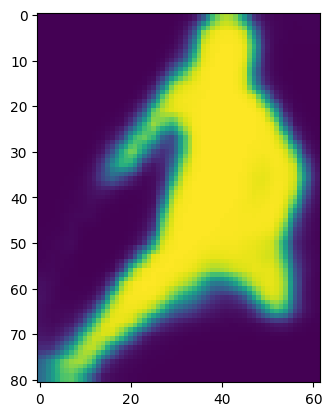

In [39]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt
box = result["bboxes__0"][1]
box_int = [int(round(i,0)) for i in box]

toresize = (box_int[2]-box_int[0],box_int[3]-box_int[1])
print(toresize)
mask = result["masks__2"][1]
print(mask.shape)
origin_shape = mask.shape
re_mask = mask.reshape(28,28,1)
re_re_mask = cv2.resize(re_mask,dsize=(toresize[0],toresize[1]))
print(re_re_mask.shape)
# re_mask = mask.reshape(toresize[0],toresize[1],origin_shape[0])
plt.imshow(re_re_mask)
plt.show()

## pipeline inference (preprocess - model - postprocess within triton server) *only-for-segmentation , object-detection is same

In [1]:
import argparse
from concurrent.futures import ThreadPoolExecutor, wait
import time
import tritonclient.http as httpclient
from tqdm import tqdm
from PIL import Image
import numpy as np
from modules.labels import COCO_NAMES

def inference(model_name,image_file,task_type,mode="single",print_output=True,n_reqs=1):
    e = time.time()
    if task_type == "seg":
        pred = client_v2(image_file, model_name,task_type, print_output)
    elif task_type == "od":
        pred = client_v1(image_file, model_name,task_type, print_output)
    s = time.time()    
    print('speed:', (s - e))
    return pred

def client_v1(image_file, model_name,task_type, print_output=True):
    img = np.array(Image.open(image_file))
    img = np.ascontiguousarray(img.transpose(2, 0, 1))
    # Define model's inputs
    inputs = []
    inputs.append(httpclient.InferInput('image__0', img.shape, "UINT8"))
    inputs[0].set_data_from_numpy(img)
    # Define model's outputs
    outputs = []
    if task_type == "seg":
        outputs.append(httpclient.InferRequestedOutput('bboxes__0'))
        outputs.append(httpclient.InferRequestedOutput('classes__1'))
        outputs.append(httpclient.InferRequestedOutput('masks__2'))
        outputs.append(httpclient.InferRequestedOutput('scores__3'))
        outputs.append(httpclient.InferRequestedOutput('shape__4'))
    elif task_type == "od":
        outputs.append(httpclient.InferRequestedOutput('bboxes__0'))
        outputs.append(httpclient.InferRequestedOutput('classes__1'))
        outputs.append(httpclient.InferRequestedOutput('scores__2'))
        outputs.append(httpclient.InferRequestedOutput('shape__3'))
        
    # Send request to Triton server
    triton_client = httpclient.InferenceServerClient(
        url="localhost:8000", verbose=False)
    results = triton_client.infer(model_name, inputs=inputs, outputs=outputs)
    response_info = results.get_response()
    outputs = {}
    
    for output_info in response_info['outputs']:
        output_name = output_info['name']
        outputs[output_name] = results.as_numpy(output_name)
        
    return outputs


def client_v2(image_file, model_name,task_type, print_output=False):
    with open(image_file, 'rb') as fi:
        image_bytes = fi.read()
    image_bytes = np.array([image_bytes], dtype=np.bytes_)
    # Define model's inputs
    inputs = []
    inputs.append(httpclient.InferInput('IMAGE_BYTES', image_bytes.shape, "BYTES"))
    inputs[0].set_data_from_numpy(image_bytes)
    # Define model's outputs
    outputs = []
    
    if task_type == "seg":
        outputs.append(httpclient.InferRequestedOutput('BBOXES'))
        outputs.append(httpclient.InferRequestedOutput('CLASSES'))
        outputs.append(httpclient.InferRequestedOutput('MASKS'))
        outputs.append(httpclient.InferRequestedOutput('SCORES'))
    elif task_type == "od":
        outputs.append(httpclient.InferRequestedOutput('bboxes__0'))
        outputs.append(httpclient.InferRequestedOutput('classes__1'))
        outputs.append(httpclient.InferRequestedOutput('scores__2'))
        outputs.append(httpclient.InferRequestedOutput('shape__3'))
    # Send request to Triton server
    triton_client = httpclient.InferenceServerClient(
        url="localhost:8000", verbose=False)
    results = triton_client.infer(model_name, inputs=inputs, outputs=outputs)
    response_info = results.get_response()
    outputs = {}
    for output_info in response_info['outputs']:
        output_name = output_info['name']
        outputs[output_name] = results.as_numpy(output_name)

    return outputs
    
def get_key_from_value(dict,value):
   return [k for k, v in dict.items() if v == value]

def infer_result_filter(pred,task_type,score:float,class_name:str):
    # get filtered index
    idx_list, new_pred = [], {}
    
    for key in list(pred.keys()):
        new_pred[key] = []
        
    if task_type == "seg":
        for i in range(len(pred[list(pred.keys())[0]])):
            if pred[list(pred.keys())[0]][i] >= score and pred[list(pred.keys())[2]][i] == get_key_from_value(COCO_NAMES,class_name)[0]:
                idx_list.append(i)
            
        # filter result
        for idx in idx_list: 
            for key in list(pred.keys())[:4]:
                if len(new_pred[key]) == 0:
                    new_pred[key] = [pred[key][idx]]
                else : new_pred[key].append(pred[key][idx])
                
    elif task_type == "od":
        for i in range(len(pred[list(pred.keys())[2]])):
            if pred[list(pred.keys())[2]][i] >= score and pred[list(pred.keys())[1]][i] == get_key_from_value(COCO_NAMES,class_name)[0]:
                idx_list.append(i)
            
        # filter result
        for idx in idx_list: 
            for key in list(pred.keys())[:3]:
                if len(new_pred[key]) == 0:
                    new_pred[key] = [pred[key][idx]]
                else : new_pred[key].append(pred[key][idx])
            
        
        new_pred[list(pred.keys())[-1]] = pred[list(pred.keys())[-1]]
    
    return new_pred


In [12]:
model_name = "faster_rcnn"
image_path = "/home/tbelldev/workspace/autoLabeling/dataset/coco_person/images/val/000000326542.jpg"
task_type = "od"
pred = inference(model_name,image_path,task_type)
result = infer_result_filter(pred,task_type,0.50,"person")
print(result)

speed: 0.09057855606079102
{'bboxes__0': [array([385.2885 , 315.53107, 465.42682, 422.2024 ], dtype=float32), array([496.53244, 285.7312 , 504.81918, 307.16663], dtype=float32), array([508.2699 , 292.97205, 514.19885, 304.17773], dtype=float32), array([192.71638, 266.22418, 200.31398, 278.29358], dtype=float32)], 'classes__1': [0, 0, 0, 0], 'scores__2': [0.9994004, 0.96035165, 0.7455567, 0.6445895], 'shape__3': array([480, 640])}


In [27]:
model_name = "infer_pipeline"
image_path = "/home/tbelldev/workspace/autoLabeling/dataset/coco_person/images/val/000000248112.jpg"
task_type = "seg"
pred = inference(model_name,image_path,task_type)
result = infer_result_filter(pred,task_type,0.60,"person")
print(result['MASKS'])

speed: 1.3895924091339111
[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]


In [28]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt

# print(result["MASKS"][0].shape)
merge = np.zeros((result["MASKS"][0].shape[0], result["MASKS"][0].shape[1]))
for i in range(len(result["MASKS"])):
    merge += result["MASKS"][i]

In [29]:
# transe = np.where(result > 0,255,0)
transe2 = np.where(merge > 0,255,0)


cv2.imwrite('images/mask/'+image_path.split("/")[-1].split(".")[0]+'.png',transe2)

origin = cv2.imread(image_path)
file_name=image_path.split("/")[-1]
cv2.imwrite("images/"+file_name,origin)
mask_path = "/home/tbelldev/workspace/autoLabeling/api_test/images/mask/"+image_path.split("/")[-1].split(".")[0]+".png"
mask_img = Image.open(mask_path)

### mask image -> coco json format

In [14]:
from PIL import Image                                      # (pip install Pillow)
import numpy as np                                         # (pip install numpy)
from skimage import measure                                # (pip install scikit-image)
from shapely.geometry import Polygon, MultiPolygon         # (pip install Shapely)
import os
import json


def create_sub_masks(mask_image, width, height):
    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            # Get the RGB values of the pixel
            pixel = mask_image.getpixel((x,y))[:3]

            # Check to see if we have created a sub-mask...
            pixel_str = str(pixel)
            sub_mask = sub_masks.get(pixel_str)
            if sub_mask is None:
               # Create a sub-mask (one bit per pixel) and add to the dictionary
                # Note: we add 1 pixel of padding in each direction
                # because the contours module doesn"t handle cases
                # where pixels bleed to the edge of the image
                sub_masks[pixel_str] = Image.new("1", (width+2, height+2))

            # Set the pixel value to 1 (default is 0), accounting for padding
            sub_masks[pixel_str].putpixel((x+1, y+1), 1)

    return sub_masks

def create_sub_mask_annotation(sub_mask):
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(np.array(sub_mask), 0.5, positive_orientation="low")

    polygons = []
    segmentations = []
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)
        
        if(poly.is_empty):
            # Go to next iteration, dont save empty values in list
            continue

        polygons.append(poly)

        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)
    
    return polygons, segmentations

/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [16]:
_, segmentations = create_sub_mask_annotation(transe2)
segmentations

[[-1.0,
  105.00196078431372,
  3.0,
  105.00196078431372,
  3.9980392156862745,
  110.0,
  10.0,
  113.00196078431372,
  14.998039215686275,
  120.0,
  15.998039215686276,
  128.0,
  10.998039215686275,
  140.0,
  10.998039215686275,
  145.0,
  13.0,
  150.00196078431372,
  20.0,
  152.00196078431372,
  24.998039215686276,
  157.0,
  27.998039215686276,
  164.0,
  26.998039215686276,
  191.0,
  24.998039215686276,
  201.0,
  26.998039215686276,
  225.0,
  26.998039215686276,
  255.0,
  21.998039215686276,
  267.0,
  21.998039215686276,
  273.0,
  25.998039215686276,
  290.0,
  25.998039215686276,
  304.0,
  28.998039215686276,
  317.0,
  28.0,
  328.9980392156863,
  0.0019607843137254832,
  328.0,
  -1.0,
  105.00196078431372],
 [175.96045751633986,
  179.03758169934642,
  175.00196078431372,
  203.0,
  173.00196078431372,
  209.0,
  181.0,
  211.99803921568628,
  183.99803921568628,
  209.0,
  184.99803921568628,
  200.0,
  188.0,
  195.99803921568628,
  190.00196078431372,
  197.0,


### check if the out-put segmentation result is reasonable

In [4]:
import json
import numpy as np
import cv2
import pycocotools
from pycocotools.coco import COCO

def create_coco_dict(file):
    '''
    Creates coco dataset
    '''
    files = {}
    files['info'] = {"year": 2022, "version": "1.0", "description": "Sementic Segmentation", "date_created": "0922"}
    files['licenses'] = [{'id': 1,
      'name': 'GNU General Public License v3.0',
      'url': 'test'}]
    files["type"] = "instances"
    files['categories'] = []
    files["annotations"] = []
    files['images'] = []
    files['categories'].append({'id': 0, 'name': "0", 'supercategory': "0"})
    all_annos = 0                    
    im = cv2.imread(file, 0)
    empty = np.zeros_like(im)
    files['images'].append({'date_captured': '2021',
                              'file_name': file,
                              'id': 0,
                              'height': im.shape[0],
                              'width': im.shape[1]})
                      
    tmp = im.copy()
    #get contours of image
    contours,hierachy = cv2.findContours(tmp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #black images to draw the contours on
    blank = np.zeros_like(tmp)

    for cnt, cont in enumerate(contours):
        segmentation = []
        xmin,ymin,width,height = cv2.boundingRect(cont) #bounding box
        if width * height < 3:
            continue
        image_height = im.shape[0]
        image_width = im.shape[1]
        
        #draw contour for verification
        cv2.drawContours(empty, [cont], 0, 255, -1)

        cont = cont.flatten().tolist() #contour as 1d array has shape (x1,y1,x2,y2,...,x_n, y_n)
        #as in https://github.com/facebookresearch/Detectron/issues/100#issuecomment-362882830
        if len(cont) > 4: #only of at least 2 points are there
            segmentation.append(cont)
        else:
            continue
        if len(segmentation) == 0: #check again if segmentations are in list
            continue
        files["annotations"].append({'segmentation': segmentation,
                                      'area': width * height,
                                      'image_id': 0,
                                      'iscrowd':0,
                                      'bbox': [xmin,ymin,width,height],
                                      "category_id": 0,
                                      "id": all_annos})
        all_annos += 1
            
        cv2.imwrite("drawn_contours.png", empty)
    
    return files


In [5]:
filename = "/home/tbelldev/workspace/autoLabeling/api_test/images/mask/000000408774.png" #insert your filename here (the image with the white circle)

di = create_coco_dict(filename)
with open("test.json", "w") as handle:
    json.dump(di, handle)

#generate coco annotation -> mask image
coco_annotation = COCO("test.json")
ann_ids = coco_annotation.getAnnIds(imgIds=[0], iscrowd=None)
anns = coco_annotation.loadAnns(ann_ids)

mask = np.zeros(cv2.imread(filename,0).shape)
mask += coco_annotation.annToMask(anns[0])
cv2.imwrite("coco_out.png", mask * 255.)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


True